In [1]:
import pandas as pd
import numpy as np

#визуал
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

#другие штуки
import os

Так как данные поступали в течени года и можно было с ними начать работать с самого начала проекта, было создано несколько функций для проверки и сбора новой информации

In [94]:
def check_name_file(files: list, directory: str) -> None:
        """Переименовывает файлы в нужный формат

        Args:
            files (list): список названий файлов
            directory (str): директория данных файлов
        """
        def rename_files(str: str) -> str:
            """форматирует название файла

            Args:
                str (str): навзвание файла

            Returns:
                str: новое название файла
            """
            return '.'.join(str.replace(',', ' ').replace('.', ' ').split()[:2]) + '.xlsx'

In [95]:
DIRECTORY_fold = 'data/'

def get_list_all_files() -> list:
    """
    Returns:
        list: функция возвращает названия всех xlsx документов в нужном формате из папки data
    """
    
    ALL_FILES = []
    folds = os.listdir(DIRECTORY_fold)
    for fold in folds:
        DIRECTORY_file = DIRECTORY_fold + str(fold)
        files = os.listdir(DIRECTORY_file)
        check_name_file(files, DIRECTORY_file)
        files = os.listdir(DIRECTORY_file)
        ALL_FILES.extend(files)
    
    return ALL_FILES

Проверка формата каждого файла

In [140]:
res = {}
folds = os.listdir(DIRECTORY_fold)
for fold in folds:
    DIRECTORY_file = DIRECTORY_fold + str(fold)
    files = os.listdir(DIRECTORY_file)
    
    ls = []
    for file in files:
        some_name = pd.read_excel(f'data/{fold}/{file}')
        finall = [file.split('.')[0], some_name.shape[1]]
        ls.append(finall)
    res[int(fold)] = ls

In [96]:
ALL_FILES = get_list_all_files()

In [97]:
def conversion(df):
    if len(df.columns) > 20:
        raise TypeError('Не подходящий формат')
    else:
        df.drop('Unnamed: 1', axis=1, inplace=True)
        df['Unnamed: 3'] = df['Unnamed: 3'].apply(lambda x: np.nan if x == 'Наименование' else x)
        df.dropna(axis=0, inplace=True)
        df.set_index(np.arange(len(df.index)), inplace=True)
        df.drop(df.columns[0], axis=1, inplace=True)

        #переименовываем столбцы
        df.rename(columns={'Unnamed: 2':'num', 'Unnamed: 3':'ration', 'Unnamed: 4':'address',
                        'Unnamed: 5':'start', 'Unnamed: 6':'finish',
                        'Unnamed: 7':'comment'}, inplace=True)

        # функция которая сокращает название рациона
        def edit_ration_name(name):
            if 'Снижение' in name:
                return name.replace('Снижение', '').strip()
            elif 'Баланс' in name:
                return name.replace('Баланс', '').strip()
            elif 'Classic' in name:
                return name.replace('Classic', '').strip()
            elif 'Набор' in name:
                return name.replace('Набор', '').strip()

        df['start'] = df['start'].apply(lambda x: int(x[0]) if len(x) <= 4 else int(x[:2])) # заменяем начало интервала со строкого формата на числовой
        df['finish'] = df['finish'].apply(lambda x: int(x[0]) if len(x) <= 4 else int(x[:2]))# заменяем конец интервала со строкого формата на числовой
        df['ration'] = df['ration'].apply(edit_ration_name)
    
        return df

In [98]:
def get_df(files: str) -> pd.DataFrame:
    """
    Args:
        files (str): Ссписок названий файлов

    Returns:
        pd.DataFrame: датасэт из всех xlsx файлов в формате DataFrame
    """
    for i, file in enumerate(ALL_FILES):
        month = int(file.split('.')[1])
        if i == 0:
            data = pd.read_excel(f'data/{month}/{file}')
            data = conversion(data)
            data['date'] = [file.split('.')[:2]] * len(data)
            lenght = len(data)
        else:
            try:
                data_plus = pd.read_excel(f'data/{month}/{file}')
                data_plus = conversion(data_plus)
                data_plus['date'] = [file.split('.')[:2]] * len(data_plus)
                lenght += len(data_plus)
                data = pd.concat([data, data_plus], axis=0)
            except Exception:
                continue
    
    data = data.drop(['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], axis=1)
    print(f'data shape is {data.shape} should equal {lenght}')

    return data

In [99]:
df = get_df(ALL_FILES)

data shape is (111619, 8) should equal 111619


**was 111619**

### Преоброзование датасэта

___

In [100]:
df_test = df.copy(deep=True)

In [101]:
df_test

,num,ration,address,start,finish,comment,date,С
0,2401387,1500,"Ревда, ул Энгельса, 38 , кв. 5, эт. 1, домоф. ...",6,8,,"[16, 08]",NaN
1,2401372,1500,"Россия, Свердловская область, Ревда, улица Энг...",6,8,,"[16, 08]",NaN
2,2371573,1500,"Россия, Свердловская область, Ревда, Рябиновая...",6,8,Сдача 1000р. | частный дом,"[16, 08]",NaN
3,2359227,1000,"Светлая улица, 40, Ревда, Свердловская область",6,8,Позвонить на телефон. по навигатору на Светлую...,"[16, 08]",NaN
4,2400974,2000,"Россия, Свердловская область, Ревда, улица Мак...",6,8,Пожалуйста доставить еду с 6:00 до 07:00 потом...,"[16, 08]",NaN
...,...,...,...,...,...,...,...,...
885,2579595,2000,"Россия, Свердловская область, Екатеринбург, ми...",9,11,,"[28, 11]",NaN
886,2526453,5 блюд 3 дня,"улица Шаумяна, 24, микрорайон Юго-Западный, Ек...",10,12,Не звонить на телефон;,"[28, 11]",NaN
887,2523691,5 блюд 3 дня,"улица Шаумяна, 24, микрорайон Юго-Западный, Ек...",10,12,Не звонить на телефон;,"[28, 11]",NaN
888,2549887,3500,"Екатеринбург, ул Шаумяна, 24 , кв. 82, эт. 10,...",10,12,Не звонить на телефон | в домофон и в дверной ...,"[28, 11]",NaN


In [102]:
# Признак date преобразуем в формат datetime
df_test['date'] = df_test['date'].apply(lambda x: '/'.join(x) + '/2022')
df_test['date'] = pd.to_datetime(df_test['date'], format='%d/%m/%Y')

# Выделяем отдельные признаки месяца, дня месяца и дня недели
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['dow'] = df_test['date'].dt.day_of_week

df_test = df_test.drop(['date'], axis=1)

In [103]:
ration_new_dict = {
    '5 блюд 3 дня': 'M',
    '6 блюд 3 дня': 'L',
    '4 блюда 3 дня': 'S',
    '3 блюда 3 дня': 'XS',
    '5 блюд 2 дня': 'M (2)',
    '4 блюда 2 дня': 'S (2)',
    '6 блюд 2 дня': 'L (2)',
    '3 блюда 2 дня': 'XS (2)'
    }

priсe_list ={
    '1500': 650, '1000': 600, '2000': 700, '750': 550, '2500': 770,
    'M': 610, 'L': 670, 'S': 550, '3500': 850, 'XS': 500, 'M (2)': 320, 'L (2)': 330,
    '1500 (1)': 330, '1000 (1)': 300, 'S (2)': 360, '2000 (1)': 350,
    '750 (1)': 280, 'XS (2)': 330, '2500 (1)': 390, '1200': 630,
    '3500 (1)': 430, '1800': 680, '2400': 750
    }

month_dict = {
    1:'January', 2:'February', 3:'March', 4:'April',
    5:'May', 6:'June', 7:'July', 8:'August',
    9:'September', 10:'October', 11:'November', 12:'December'
    }

df_test['ration'] = df_test['ration'].apply(lambda x: ration_new_dict[x] if x in ration_new_dict.keys() else x)
df_test['price'] = df_test['ration'].map(priсe_list)
df_test['month_st'] = df_test['month'].map(month_dict)

In [104]:
df_test = df_test.drop(['num', 'comment'], axis=1)
df_test.reset_index(inplace=True, drop=True)

In [106]:
exp = df_test[df_test['month'] == 1]
exp['day'].nunique()

27

In [107]:
df_test.groupby(['month'])['day'].nunique()

month
1     27
2     26
3     28
4     13
5      8
6     15
7     21
8     24
9     24
10    30
11    23
12    12
Name: day, dtype: int64

___

### EDA

In [22]:
df

,num,ration,address,start,finish,comment,month,day,price,month_st
0,2404378,2000,"Екатеринбург, ул Щербакова, 18 , кв. 234, эт. ...",6,8,,8,20,700.0,August
1,2391392,1500,"Екатеринбург, ул Гастелло, 32 , кв. 22, эт. 5,...",6,8,,8,20,650.0,August
2,2402533,M,"Рощинская улица, 21к3, Екатеринбург, Свердловс...",6,8,,8,20,610.0,August
3,2401369,1000,"улица Орденоносцев, 10, микрорайон Химмаш, Чка...",6,8,Одноподьездный дом,8,20,600.0,August
4,2394314,1000,"Россия, Свердловская область, муниципальное об...",6,8,,8,20,600.0,August
...,...,...,...,...,...,...,...,...,...,...
252,2532264,750,"Екатеринбург, ул Академика Шварца, 6к2 , кв. 2...",10,12,,11,6,550.0,November
253,2532266,1000,"Екатеринбург, ул Академика Шварца, 6к2 , кв. 2...",10,12,,11,6,600.0,November
254,2535332,750,"Родонитовая улица, 5, Екатеринбург, Свердловск...",10,12,,11,6,550.0,November
255,2531922,1500,"Россия, Свердловская область, Екатеринбург, ми...",10,12,,11,6,650.0,November


In [26]:
ration = df['ration'].value_counts().sort_values(ascending=False)[:15]
ration = pd.DataFrame({'ration': ration.index, 'count': ration.values})

In [27]:
start = df['start'].value_counts()
start = start.sort_values(ascending=False)
start = pd.DataFrame({'start': start.index, 'count': start.values})

In [40]:

ration_list = df['ration'].value_counts().index.to_list()
print(ration_list, sep=' ')


['1500', '1000', '2000', '750', '2500', 'M', 'L', '3500', 'S', 'XS', 'M (2)', '1500 (1)', 'L (2)', '5 блюд 3 дня', '1000 (1)', 'S (2)', '2000 (1)', '6 блюд 3 дня', '4 блюда 3 дня', '750 (1)', 'XS (2)', '2500 (1)', '3 блюда 3 дня', '1200', '5 блюд 2 дня', '3500 (1)', '1800', '1500 (1) зеленая', '4 блюда 2 дня', '1000 (1) зеленая', '2000 (1) зеленая', '6 блюд 2 дня', '2400', '750 (1) зеленая', '3 блюда 2 дня', '2500 (1) зеленая']


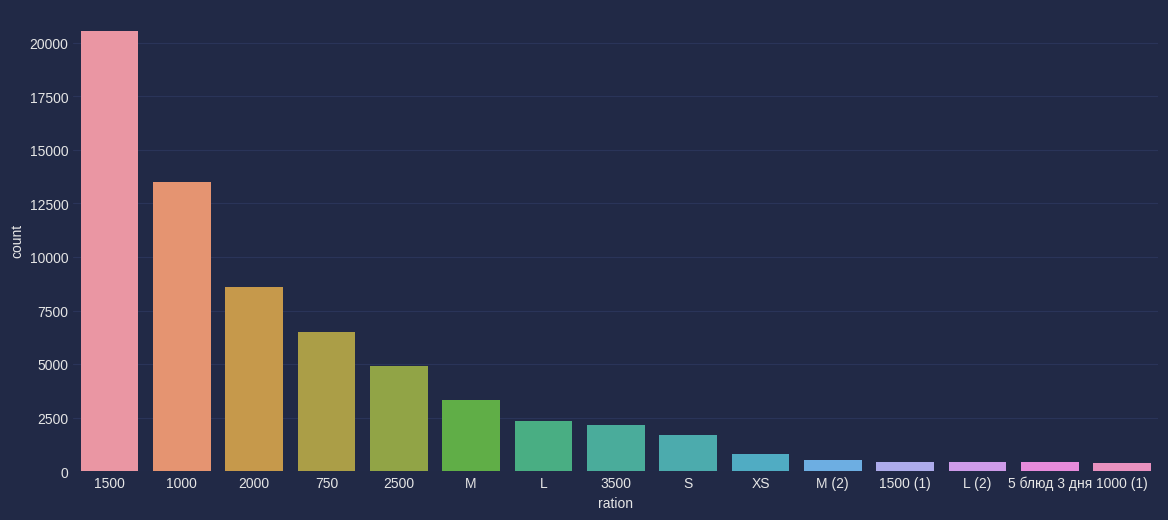

In [28]:
fig = plt.figure(figsize=(14, 6))

sns.barplot(x=ration['ration'], y=ration['count']);

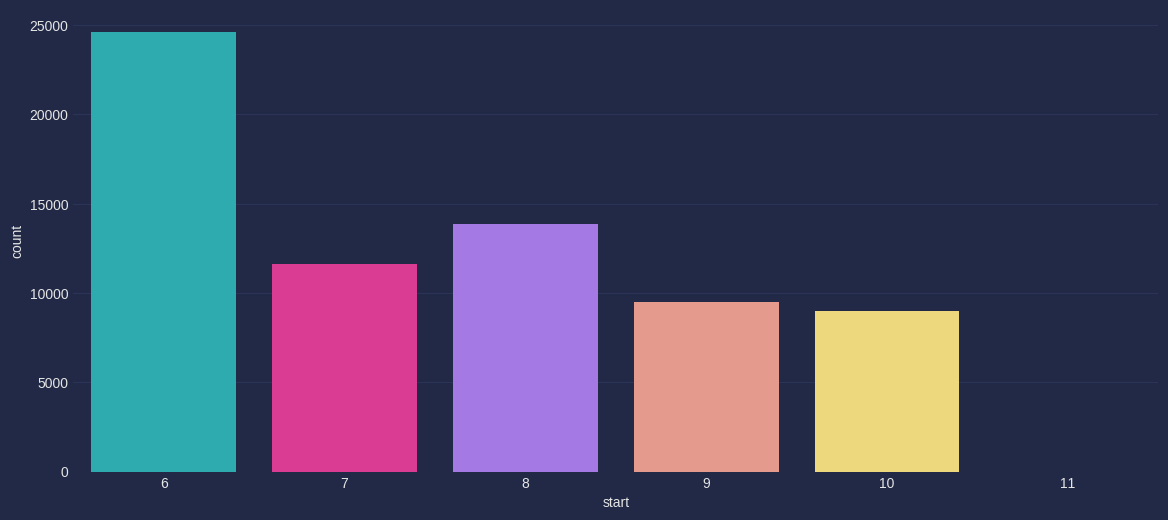

In [29]:
fig = plt.figure(figsize=(14, 6))

sns.barplot(x=start['start'], y=start['count']);

In [183]:
coef = []

for fold in sorted(list(map(int, os.listdir(DIRECTORY_fold)))):
    DIRECTORY_file = DIRECTORY_fold + '/' + str(fold)
    files = os.listdir(DIRECTORY_file)
    coef.append((fold, len(files)))

coef = np.array([1 + (1 - i[1] / 30) for i in coef])

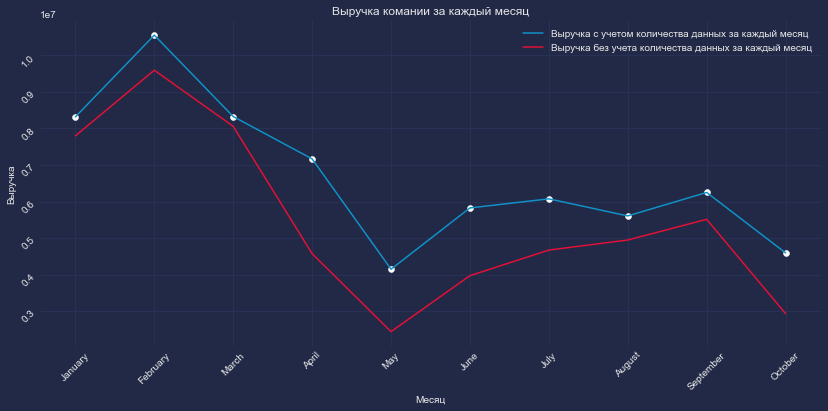

In [188]:
group_m = df.groupby(['month','month_st'])['price'].sum()
month_list = [x[1] for x in list(group_m.index)]

fig = plt.figure(figsize=(14, 6))

scater = sns.scatterplot(x=month_list, y=group_m.values * coef, color='#fff')
line = sns.lineplot(x=month_list, y=group_m.values * coef, color='#1092c9', label='Выручка с учетом количества данных за каждый месяц')
line2 = sns.lineplot(x=month_list, y=group_m.values, color='#e31037', label='Выручка без учета количества данных за каждый месяц')

line.set(title='Выручка комании за каждый месяц', xlabel='Месяц', ylabel='Выручка')
line.yaxis.set_tick_params(rotation=45)
line.xaxis.set_tick_params(rotation=45)

___

In [200]:
s = 0

for fold in sorted(list(map(int, os.listdir(DIRECTORY_fold)))):
    DIRECTORY_file = DIRECTORY_fold + '/' + str(fold)
    files = os.listdir(DIRECTORY_file)
    s += len(files)

df['num'] = df['num'].map(int)
(df['num'].count()) / s

In [194]:
df

,num,ration,address,start,finish,comment,month,day,price,month_st
0,1922333,1500,"Россия, Свердловская область, Екатеринбург, Ор...",6,8,,1,2,650,January
1,1922329,1500,"Россия, Свердловская область, Екатеринбург, Ор...",6,8,,1,2,650,January
2,1906894,M,"Россия, Свердловская область, Екатеринбург, ул...",6,8,позвонить за полчаса.,1,2,610,January
3,1927891,2500,"улица Феофанова, 2Г, Верхняя Пышма, Свердловск...",6,8,,1,2,770,January
4,1928999,1500,"Верхняя Пышма, село Балтым, ул Васильковая, 5 ...",7,9,Сдача 67р.,1,2,650,January
...,...,...,...,...,...,...,...,...,...,...
412,2471407,1500,"Свердловская область, Екатеринбург, улица 8 Ма...",10,12,,9,30,650,September
413,2474825,1500,"улица Белинского, 161, Екатеринбург, Свердловс...",10,12,,9,30,650,September
414,2476654,1000,"Россия, Свердловская область, Екатеринбург, Ма...",10,12,"2 ворота, вход со двора",9,30,600,September
415,2467237,750,"Екатеринбург, ул Белинского, 182 , кв. 222, эт...",10,12,,9,30,550,September


In [192]:
def make_address_col(df):

    #список адресов
    list_of_address = list(df['address'])
    list_of_address = [elem.replace('пр-кт', 'проспект') for elem in list_of_address]
    # список адресов дальняков
    area_list = ['Первоуральск', 'Верхняя Пышма', 'Ревда', 'Берёзовский', 'Заречный', 'деревня', 
                   'посёлок', 'район', 'микрорайон', 'СНТ', 'Среднеуральск', 'Полевской']

    #созадем списки улицы, номера дома и города
    street_list, house_list, area_true_list = [], [], []
    for elem in list_of_address:
        ls = elem.split(',')
        for ind, name in enumerate(ls):
            if 'ул' in name or 'улица' in name or 'проспект' in name or 'переулок' in name:
                street_list.append(name)
                house_list.append(ls[ind + 1])
            else:
                street_list.append('другое')

    def get_area(address):
    #функция возвращает город адреса доставки
        for elem in address.split(','):
            if elem in area_list:
                return elem
            else:
                return 'Екатеринбург'

    def get_true_num(num):
    #функция меняет номер дома с корпусом на номер дома с корпусом,но уже без буквы "к" для geocodera
        new_num = ''
        for i in num:
            if i == 'к':
                new_num += '/'
            else:
                new_num += i
        return new_num

    df['street'] = street_list
    df['house'] = house_list
    df['house'] = df['house'].apply(get_true_num)
    df['area'] = df['address'].apply(get_area)
    df['short_address'] = df['street'] + ',' + df['house'] + ',' + df['area']
    
    return df

In [193]:
clear_data = make_address_col(df)

IndexError: list index out of range

In [ ]:
xlim = (56.760482, 60.392160), (56.761477, 60.826150)
ylim = (60.392160, 56.760482), (56.974103, 60.380835)